# Implementation of CheXNet

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from PIL import Image
from tqdm.auto import tqdm
from typing import Dict
from pathlib import Path
import logging
import time
from prettytable import PrettyTable
from copy import deepcopy

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import densenet121
from torch.optim import Adam, lr_scheduler
import torchvision.transforms as tfms
import torchvision.transforms.functional as T

import albumentations as A
from albumentations.pytorch import ToTensorV2

## Config

In [5]:
class CFG:
    CLASS_NAMES = [
        "Atelectasis",
        "Cardiomegaly",
        "Effusion",
        "Infiltration",
        "Mass",
        "Nodule",
        "Pneumonia",
        "Pneumothorax",
        "Consolidation",
        "Edema",
        "Emphysema",
        "Fibrosis",
        "Pleural_Thickening",
        "Hernia",
    ]
    BASE_PATH = Path("/kaggle/input/nih-chest-x-ray-14-224x224-resized")
    BEST_MODEL_PATH = "models/best_model.pt"
    EPOCHS = 20
    DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    INTERVAL = 10

In [6]:
CFG.DEVICE

device(type='cuda')

## Process Images and labels

In [7]:
df = pd.read_csv( CFG.BASE_PATH / "Data_Entry_2017.csv")

In [8]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,058Y,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,058Y,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,058Y,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,081Y,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,081Y,F,PA,2582,2991,0.143,0.143,NaN


In [9]:
df = df[["Image Index", "Finding Labels"]]

In [10]:
df.head()

,Image Index,Finding Labels
0,00000001_000.png,Cardiomegaly
1,00000001_001.png,Cardiomegaly|Emphysema
2,00000001_002.png,Cardiomegaly|Effusion
3,00000002_000.png,No Finding
4,00000003_000.png,Hernia


In [11]:
# Make paths absolute
df["Image Index"] = [
    CFG.BASE_PATH / f"images-224/images-224/{path}" for path in df["Image Index"].values
]
# Remove "No Finding"
df = df[df["Finding Labels"].isin(["No Finding"]) == False]

In [12]:
df.head(10)

,Image Index,Finding Labels
0,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...,Cardiomegaly
1,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...,Cardiomegaly|Emphysema
2,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...,Cardiomegaly|Effusion
4,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...,Hernia
5,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...,Hernia
6,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...,Hernia
7,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...,Hernia|Infiltration
8,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...,Hernia
9,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...,Hernia
10,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...,Hernia


In [13]:
labels = np.zeros(shape=(len(df), 14))
for idx, lab in tqdm(enumerate(df["Finding Labels"].values), total=len(df)):
    lbls = lab.split("|")
    lbl_arr = np.zeros(len(CFG.CLASS_NAMES))
    for l in lbls:
        lbl_arr[CFG.CLASS_NAMES.index(l)] = 1
    labels[idx] = lbl_arr

  0%|          | 0/51708 [00:00<?, ?it/s]

In [14]:
labels

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
d = {k:v for k, v in zip(CFG.CLASS_NAMES, labels.transpose())}

In [16]:
for k, v in d.items():
    df[k] = v 

In [17]:
df.head()

,Image Index,Finding Labels,Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,Nodule,Pneumonia,Pneumothorax,Consolidation,Edema,Emphysema,Fibrosis,Pleural_Thickening,Hernia
0,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...,Cardiomegaly,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...,Cardiomegaly|Emphysema,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...,Cardiomegaly|Effusion,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...,Hernia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...,Hernia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [18]:
df.to_csv("final.csv", index=False)

## Plotting images

Now we have our Images and one-hot encoded labels, let's view a few of them

In [19]:
def plot_images(df, rows, columns, figsize=(20, 20)):
    """
    Function to plot images
    """
    fig, axs = plt.subplots(rows, columns, figsize=figsize)
    idx = 0
    for i in range(rows):
        for j in range(columns):
            image = np.asarray(Image.open(df["Image Index"].values[idx]).convert("RGB"))
            labels = df["Finding Labels"].values[idx].split("|")
            axs[i, j].imshow(image)
            axs[i, j].yaxis.set_visible(False)
            axs[i, j].set_xticklabels([])
            axs[i, j].set_xlabel(labels)
            idx += 1
    plt.show()

## Read the saved data

In [20]:
df = pd.read_csv("./final.csv")

In [21]:
df.head()

,Image Index,Finding Labels,Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,Nodule,Pneumonia,Pneumothorax,Consolidation,Edema,Emphysema,Fibrosis,Pleural_Thickening,Hernia
0,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...,Cardiomegaly,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...,Cardiomegaly|Emphysema,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...,Cardiomegaly|Effusion,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...,Hernia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,/kaggle/input/nih-chest-x-ray-14-224x224-resiz...,Hernia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


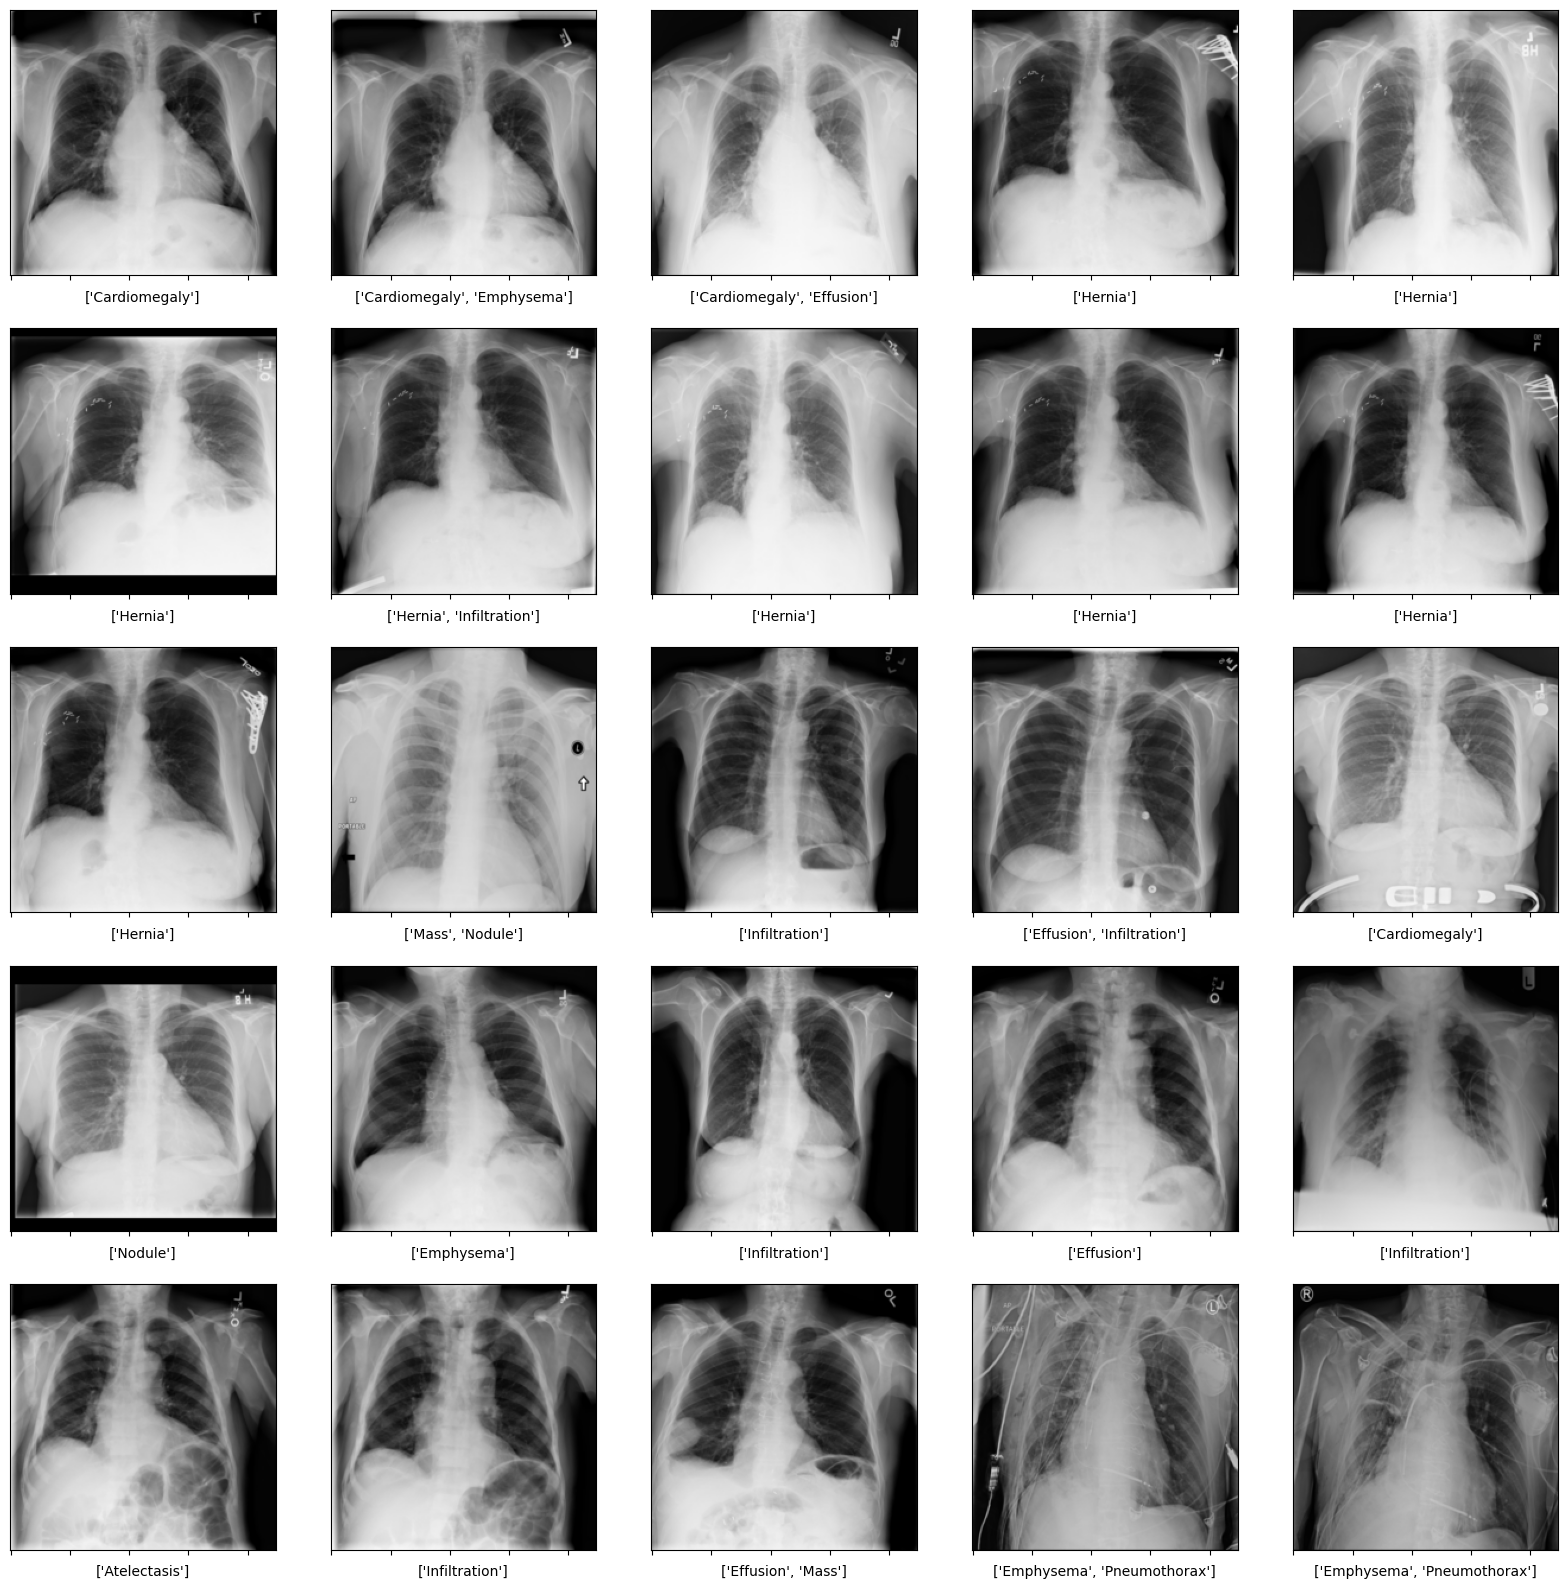

In [22]:
plot_images(df, 5, 5)

## PyTorch Dataset

In [23]:
class CheXNetData(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __getitem__(self, idx):
        image = Image.open(self.df["Image Index"].values[idx]).convert("RGB")
        label = self.df.iloc[:, 2:].values[idx]

        if self.transform:
            image = self.transform(image=np.asarray(image))["image"]

        label = torch.tensor(label, dtype=torch.float)

        return image, label

    def __len__(self):
        return len(df)

In [24]:
transforms = A.Compose(transforms=[A.Normalize(), ToTensorV2()])

In [25]:
ds = CheXNetData(df=df, transform=transforms)

In [26]:
image, label = ds[0]

In [27]:
image.size(), label.size()

(torch.Size([3, 224, 224]), torch.Size([14]))

### Split the dataset

#### Split into Train & Test

In [28]:
total = len(ds)
train_len = int(0.8 * total)
val_len = total - train_len

train_ds, test_ds = random_split(dataset=ds, lengths=[train_len, val_len])

#### Split into Train and Validation

In [29]:
total = len(train_ds)
train_len = int(0.8 * total)
val_len = total - train_len

train_ds, val_ds = random_split(dataset=train_ds, lengths=[train_len, val_len])

In [30]:
print(f"The lengths of train, val and test dataset: {len(train_ds)} images, {len(val_ds)} images, and {len(test_ds)} images")

The lengths of train, val and test dataset: 33092 images, 8274 images, and 10342 images


In [31]:
ds_size = {
    "train": len(train_ds), "val": len(val_ds), "test": len(test_ds)
} # Size dictionary

In [32]:
ds_size

{'train': 33092, 'val': 8274, 'test': 10342}

### Create the DataLoader(s)

In [33]:
loaders = {
    "train": DataLoader(train_ds, batch_size=64, shuffle=True),
    "val": DataLoader(val_ds, batch_size=32),
    "test": DataLoader(test_ds, batch_size=32)
}

In [34]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7b2144ef2200>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7b2144ef2230>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7b2144ef3460>}

## PyTorch Model

In [35]:
class DenseNet121(nn.Module):
    def __init__(self, n_classes):
        super(DenseNet121, self).__init__()

        self.densenet121 = densenet121(pretrained=True)
        n_features = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(n_features, n_classes), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.densenet121(x)
        return x

## Training

In [36]:
ds_batches = {k : len(v) for k, v in loaders.items()}
ds_batches

{'train': 518, 'val': 259, 'test': 324}

In [37]:
# check is models folder exists
Path("models").mkdir(exist_ok=True)

# Set up logger
logging.basicConfig(
    filename="train.log",
    format="%(asctime)s - %(levelname)s - %(message)s",
    level=logging.INFO,
    filemode="w",
)

###  Utilities

In [38]:
def calc_mean_auc(labels: torch.tensor, preds: torch.tensor):
    labels = labels.cpu().detach().numpy()
    preds = preds.cpu().detach().numpy()
    
    per_class_AUROC = []
    for i, name in enumerate(CFG.CLASS_NAMES):
        try:
             per_class_AUROC.append(roc_auc_score(labels[:, i], preds[:, i]))
        except ValueError:
            pass
    mean_roc_auc = np.array(per_class_AUROC).mean()
    
    return mean_roc_auc

### Run one epoch

In [43]:
best_AUROC = 0.0 # Global AUROC

def run_one_epoch(
    epoch: int,
    ds_sizes: Dict[str, int],
    dataloaders: Dict[str, DataLoader],
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    loss: nn.Module,
    scheduler: torch.optim.lr_scheduler
):
    """
    Run one complete train-val loop

    Parameter
    ---------

    ds_sizes: Dictionary containing dataset sizes
    dataloaders: Dictionary containing dataloaders
    model: The model
    optimizer: The optimizer
    loss: The loss

    Returns
    -------

    metrics: Dictionary containing metrics

    """
    global best_AUROC
    
    metrics = {}
    AUROCs = []
    
    for phase in ["train", "val"]:
        logging.info(f"{phase.upper()} phase")

        if phase == "train":
            model.train()
        else:
            model.eval()
        
        avg_loss = 0
        running_corrects = 0

        for batch_idx, (images, labels) in enumerate(
            tqdm(dataloaders[phase], total=len(dataloaders[phase]))
        ):

            images = images.to(CFG.DEVICE)
            labels = labels.to(CFG.DEVICE)

            # Zero the gradients
            optimizer.zero_grad()

            # Track history if in phase == "train"
            with torch.set_grad_enabled(phase == "train"):
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                if phase == "train":
                    loss.backward()
                    optimizer.step()
                
                # Calculate AUROC
                auroc = calc_mean_auc(labels, outputs)
                AUROCs.append(auroc)

            avg_loss += loss.item() * images.size(0)

            if batch_idx % CFG.INTERVAL == 0:
                logging.info(
                    f"Epoch {epoch} - {phase.upper()} - Batch {batch_idx} - Loss = {round(loss.item(), 3)} | AUROC = {round(auroc, 3)}"
                )

        epoch_loss = avg_loss / ds_sizes[phase]
        epoch_val_mean = np.array(AUROCs).mean()
        
        # step the scheduler
        if phase == "train":
            scheduler.step(epoch_loss)
        
        # save best model wts
        if phase == "val" and epoch_val_mean > best_AUROC:
            best_AUROC = epoch_val_mean
            best_model_wts = deepcopy(model.state_dict())
            timestampTime = time.strftime("%H%M%S")
            timestampDate = time.strftime("%d%m%Y")
            timestampEND = timestampDate + '-' + timestampTime
            best_model_path = f"models/CheXNet-{timestampEND}.pt"
            torch.save({
                "epoch" : epoch, "val_loss": epoch_loss, "val_AUROC": epoch_val_mean, "model": best_model_wts
            }, best_model_path)

        # Metrics tracking
        if phase == "train":
            metrics["train_loss"] = round(epoch_loss, 3)
        else:
            metrics["val_loss"] = round(epoch_loss, 3)
            metrics["val_mean_AUROC"] = round(epoch_val_mean, 3)

    return metrics

In [44]:
def train(dataloaders, ds_sizes, model, optimizer, criterion, scheduler):
    table = PrettyTable(
        field_names=["Epoch", "Train Loss", "Val Loss", "Val Mean AUROC"]
    )
    
    for epoch in range(CFG.EPOCHS):

        start = time.time()

        metrics = run_one_epoch(
            epoch=epoch,
            ds_sizes=ds_sizes,
            dataloaders=dataloaders,
            model=model,
            optimizer=optimizer,
            loss=criterion,
            scheduler=scheduler
        )

        end = time.time() - start

        print(f"Epoch completed in: {round(end/60, 3)} mins")

        table.add_row(
            row=[
                epoch + 1,
                metrics["train_loss"],
                metrics["val_loss"],
                metrics["val_mean_AUROC"]
            ]
        )
        print(table)

    # Write results to file
    with open("results.txt", "w") as f:
        results = table.get_string()
        f.write(results)

### Set-up Model, Optimizer & Loss

In [46]:
model = DenseNet121(n_classes=14).to(CFG.DEVICE)
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, mode='min', patience=1)

In [47]:
train(
    dataloaders=loaders, 
    ds_sizes=ds_size, 
    model=model, 
    optimizer=optimizer, 
    criterion=criterion, 
    scheduler=scheduler
)

  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

Epoch completed in: 7.144 mins
+-------+------------+----------+----------------+
| Epoch | Train Loss | Val Loss | Val Mean AUROC |
+-------+------------+----------+----------------+
|   1   |   0.284    |  0.302   |     0.691      |
+-------+------------+----------+----------------+


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

Epoch completed in: 5.779 mins
+-------+------------+----------+----------------+
| Epoch | Train Loss | Val Loss | Val Mean AUROC |
+-------+------------+----------+----------------+
|   1   |   0.284    |  0.302   |     0.691      |
|   2   |   0.273    |  0.317   |     0.709      |
+-------+------------+----------+----------------+


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

Epoch completed in: 5.773 mins
+-------+------------+----------+----------------+
| Epoch | Train Loss | Val Loss | Val Mean AUROC |
+-------+------------+----------+----------------+
|   1   |   0.284    |  0.302   |     0.691      |
|   2   |   0.273    |  0.317   |     0.709      |
|   3   |   0.269    |  0.273   |     0.735      |
+-------+------------+----------+----------------+


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

Epoch completed in: 5.791 mins
+-------+------------+----------+----------------+
| Epoch | Train Loss | Val Loss | Val Mean AUROC |
+-------+------------+----------+----------------+
|   1   |   0.284    |  0.302   |     0.691      |
|   2   |   0.273    |  0.317   |     0.709      |
|   3   |   0.269    |  0.273   |     0.735      |
|   4   |   0.265    |   0.27   |     0.748      |
+-------+------------+----------+----------------+


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

Epoch completed in: 5.835 mins
+-------+------------+----------+----------------+
| Epoch | Train Loss | Val Loss | Val Mean AUROC |
+-------+------------+----------+----------------+
|   1   |   0.284    |  0.302   |     0.691      |
|   2   |   0.273    |  0.317   |     0.709      |
|   3   |   0.269    |  0.273   |     0.735      |
|   4   |   0.265    |   0.27   |     0.748      |
|   5   |   0.264    |  0.284   |     0.752      |
+-------+------------+----------+----------------+


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

Epoch completed in: 5.848 mins
+-------+------------+----------+----------------+
| Epoch | Train Loss | Val Loss | Val Mean AUROC |
+-------+------------+----------+----------------+
|   1   |   0.284    |  0.302   |     0.691      |
|   2   |   0.273    |  0.317   |     0.709      |
|   3   |   0.269    |  0.273   |     0.735      |
|   4   |   0.265    |   0.27   |     0.748      |
|   5   |   0.264    |  0.284   |     0.752      |
|   6   |   0.261    |  0.267   |     0.759      |
+-------+------------+----------+----------------+


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

Epoch completed in: 5.734 mins
+-------+------------+----------+----------------+
| Epoch | Train Loss | Val Loss | Val Mean AUROC |
+-------+------------+----------+----------------+
|   1   |   0.284    |  0.302   |     0.691      |
|   2   |   0.273    |  0.317   |     0.709      |
|   3   |   0.269    |  0.273   |     0.735      |
|   4   |   0.265    |   0.27   |     0.748      |
|   5   |   0.264    |  0.284   |     0.752      |
|   6   |   0.261    |  0.267   |     0.759      |
|   7   |   0.259    |  0.262   |     0.765      |
+-------+------------+----------+----------------+


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

Epoch completed in: 5.711 mins
+-------+------------+----------+----------------+
| Epoch | Train Loss | Val Loss | Val Mean AUROC |
+-------+------------+----------+----------------+
|   1   |   0.284    |  0.302   |     0.691      |
|   2   |   0.273    |  0.317   |     0.709      |
|   3   |   0.269    |  0.273   |     0.735      |
|   4   |   0.265    |   0.27   |     0.748      |
|   5   |   0.264    |  0.284   |     0.752      |
|   6   |   0.261    |  0.267   |     0.759      |
|   7   |   0.259    |  0.262   |     0.765      |
|   8   |   0.258    |  0.266   |     0.767      |
+-------+------------+----------+----------------+


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

Epoch completed in: 5.725 mins
+-------+------------+----------+----------------+
| Epoch | Train Loss | Val Loss | Val Mean AUROC |
+-------+------------+----------+----------------+
|   1   |   0.284    |  0.302   |     0.691      |
|   2   |   0.273    |  0.317   |     0.709      |
|   3   |   0.269    |  0.273   |     0.735      |
|   4   |   0.265    |   0.27   |     0.748      |
|   5   |   0.264    |  0.284   |     0.752      |
|   6   |   0.261    |  0.267   |     0.759      |
|   7   |   0.259    |  0.262   |     0.765      |
|   8   |   0.258    |  0.266   |     0.767      |
|   9   |   0.257    |  0.276   |     0.764      |
+-------+------------+----------+----------------+


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

Epoch completed in: 5.737 mins
+-------+------------+----------+----------------+
| Epoch | Train Loss | Val Loss | Val Mean AUROC |
+-------+------------+----------+----------------+
|   1   |   0.284    |  0.302   |     0.691      |
|   2   |   0.273    |  0.317   |     0.709      |
|   3   |   0.269    |  0.273   |     0.735      |
|   4   |   0.265    |   0.27   |     0.748      |
|   5   |   0.264    |  0.284   |     0.752      |
|   6   |   0.261    |  0.267   |     0.759      |
|   7   |   0.259    |  0.262   |     0.765      |
|   8   |   0.258    |  0.266   |     0.767      |
|   9   |   0.257    |  0.276   |     0.764      |
|   10  |   0.256    |  0.264   |     0.771      |
+-------+------------+----------+----------------+


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

Epoch completed in: 5.748 mins
+-------+------------+----------+----------------+
| Epoch | Train Loss | Val Loss | Val Mean AUROC |
+-------+------------+----------+----------------+
|   1   |   0.284    |  0.302   |     0.691      |
|   2   |   0.273    |  0.317   |     0.709      |
|   3   |   0.269    |  0.273   |     0.735      |
|   4   |   0.265    |   0.27   |     0.748      |
|   5   |   0.264    |  0.284   |     0.752      |
|   6   |   0.261    |  0.267   |     0.759      |
|   7   |   0.259    |  0.262   |     0.765      |
|   8   |   0.258    |  0.266   |     0.767      |
|   9   |   0.257    |  0.276   |     0.764      |
|   10  |   0.256    |  0.264   |     0.771      |
|   11  |   0.255    |  0.261   |     0.776      |
+-------+------------+----------+----------------+


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

Epoch completed in: 5.727 mins
+-------+------------+----------+----------------+
| Epoch | Train Loss | Val Loss | Val Mean AUROC |
+-------+------------+----------+----------------+
|   1   |   0.284    |  0.302   |     0.691      |
|   2   |   0.273    |  0.317   |     0.709      |
|   3   |   0.269    |  0.273   |     0.735      |
|   4   |   0.265    |   0.27   |     0.748      |
|   5   |   0.264    |  0.284   |     0.752      |
|   6   |   0.261    |  0.267   |     0.759      |
|   7   |   0.259    |  0.262   |     0.765      |
|   8   |   0.258    |  0.266   |     0.767      |
|   9   |   0.257    |  0.276   |     0.764      |
|   10  |   0.256    |  0.264   |     0.771      |
|   11  |   0.255    |  0.261   |     0.776      |
|   12  |   0.253    |  0.284   |     0.772      |
+-------+------------+----------+----------------+


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

Epoch completed in: 5.738 mins
+-------+------------+----------+----------------+
| Epoch | Train Loss | Val Loss | Val Mean AUROC |
+-------+------------+----------+----------------+
|   1   |   0.284    |  0.302   |     0.691      |
|   2   |   0.273    |  0.317   |     0.709      |
|   3   |   0.269    |  0.273   |     0.735      |
|   4   |   0.265    |   0.27   |     0.748      |
|   5   |   0.264    |  0.284   |     0.752      |
|   6   |   0.261    |  0.267   |     0.759      |
|   7   |   0.259    |  0.262   |     0.765      |
|   8   |   0.258    |  0.266   |     0.767      |
|   9   |   0.257    |  0.276   |     0.764      |
|   10  |   0.256    |  0.264   |     0.771      |
|   11  |   0.255    |  0.261   |     0.776      |
|   12  |   0.253    |  0.284   |     0.772      |
|   13  |   0.253    |  0.269   |     0.776      |
+-------+------------+----------+----------------+


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

Epoch completed in: 5.701 mins
+-------+------------+----------+----------------+
| Epoch | Train Loss | Val Loss | Val Mean AUROC |
+-------+------------+----------+----------------+
|   1   |   0.284    |  0.302   |     0.691      |
|   2   |   0.273    |  0.317   |     0.709      |
|   3   |   0.269    |  0.273   |     0.735      |
|   4   |   0.265    |   0.27   |     0.748      |
|   5   |   0.264    |  0.284   |     0.752      |
|   6   |   0.261    |  0.267   |     0.759      |
|   7   |   0.259    |  0.262   |     0.765      |
|   8   |   0.258    |  0.266   |     0.767      |
|   9   |   0.257    |  0.276   |     0.764      |
|   10  |   0.256    |  0.264   |     0.771      |
|   11  |   0.255    |  0.261   |     0.776      |
|   12  |   0.253    |  0.284   |     0.772      |
|   13  |   0.253    |  0.269   |     0.776      |
|   14  |   0.252    |  0.263   |     0.781      |
+-------+------------+----------+----------------+


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

Epoch completed in: 5.696 mins
+-------+------------+----------+----------------+
| Epoch | Train Loss | Val Loss | Val Mean AUROC |
+-------+------------+----------+----------------+
|   1   |   0.284    |  0.302   |     0.691      |
|   2   |   0.273    |  0.317   |     0.709      |
|   3   |   0.269    |  0.273   |     0.735      |
|   4   |   0.265    |   0.27   |     0.748      |
|   5   |   0.264    |  0.284   |     0.752      |
|   6   |   0.261    |  0.267   |     0.759      |
|   7   |   0.259    |  0.262   |     0.765      |
|   8   |   0.258    |  0.266   |     0.767      |
|   9   |   0.257    |  0.276   |     0.764      |
|   10  |   0.256    |  0.264   |     0.771      |
|   11  |   0.255    |  0.261   |     0.776      |
|   12  |   0.253    |  0.284   |     0.772      |
|   13  |   0.253    |  0.269   |     0.776      |
|   14  |   0.252    |  0.263   |     0.781      |
|   15  |   0.251    |  0.272   |     0.781      |
+-------+------------+----------+----------------+


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

Epoch completed in: 5.708 mins
+-------+------------+----------+----------------+
| Epoch | Train Loss | Val Loss | Val Mean AUROC |
+-------+------------+----------+----------------+
|   1   |   0.284    |  0.302   |     0.691      |
|   2   |   0.273    |  0.317   |     0.709      |
|   3   |   0.269    |  0.273   |     0.735      |
|   4   |   0.265    |   0.27   |     0.748      |
|   5   |   0.264    |  0.284   |     0.752      |
|   6   |   0.261    |  0.267   |     0.759      |
|   7   |   0.259    |  0.262   |     0.765      |
|   8   |   0.258    |  0.266   |     0.767      |
|   9   |   0.257    |  0.276   |     0.764      |
|   10  |   0.256    |  0.264   |     0.771      |
|   11  |   0.255    |  0.261   |     0.776      |
|   12  |   0.253    |  0.284   |     0.772      |
|   13  |   0.253    |  0.269   |     0.776      |
|   14  |   0.252    |  0.263   |     0.781      |
|   15  |   0.251    |  0.272   |     0.781      |
|   16  |    0.25    |  0.263   |     0.782      |


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

Epoch completed in: 5.677 mins
+-------+------------+----------+----------------+
| Epoch | Train Loss | Val Loss | Val Mean AUROC |
+-------+------------+----------+----------------+
|   1   |   0.284    |  0.302   |     0.691      |
|   2   |   0.273    |  0.317   |     0.709      |
|   3   |   0.269    |  0.273   |     0.735      |
|   4   |   0.265    |   0.27   |     0.748      |
|   5   |   0.264    |  0.284   |     0.752      |
|   6   |   0.261    |  0.267   |     0.759      |
|   7   |   0.259    |  0.262   |     0.765      |
|   8   |   0.258    |  0.266   |     0.767      |
|   9   |   0.257    |  0.276   |     0.764      |
|   10  |   0.256    |  0.264   |     0.771      |
|   11  |   0.255    |  0.261   |     0.776      |
|   12  |   0.253    |  0.284   |     0.772      |
|   13  |   0.253    |  0.269   |     0.776      |
|   14  |   0.252    |  0.263   |     0.781      |
|   15  |   0.251    |  0.272   |     0.781      |
|   16  |    0.25    |  0.263   |     0.782      |


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

Epoch completed in: 5.74 mins
+-------+------------+----------+----------------+
| Epoch | Train Loss | Val Loss | Val Mean AUROC |
+-------+------------+----------+----------------+
|   1   |   0.284    |  0.302   |     0.691      |
|   2   |   0.273    |  0.317   |     0.709      |
|   3   |   0.269    |  0.273   |     0.735      |
|   4   |   0.265    |   0.27   |     0.748      |
|   5   |   0.264    |  0.284   |     0.752      |
|   6   |   0.261    |  0.267   |     0.759      |
|   7   |   0.259    |  0.262   |     0.765      |
|   8   |   0.258    |  0.266   |     0.767      |
|   9   |   0.257    |  0.276   |     0.764      |
|   10  |   0.256    |  0.264   |     0.771      |
|   11  |   0.255    |  0.261   |     0.776      |
|   12  |   0.253    |  0.284   |     0.772      |
|   13  |   0.253    |  0.269   |     0.776      |
|   14  |   0.252    |  0.263   |     0.781      |
|   15  |   0.251    |  0.272   |     0.781      |
|   16  |    0.25    |  0.263   |     0.782      |
|

  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

Epoch completed in: 5.704 mins
+-------+------------+----------+----------------+
| Epoch | Train Loss | Val Loss | Val Mean AUROC |
+-------+------------+----------+----------------+
|   1   |   0.284    |  0.302   |     0.691      |
|   2   |   0.273    |  0.317   |     0.709      |
|   3   |   0.269    |  0.273   |     0.735      |
|   4   |   0.265    |   0.27   |     0.748      |
|   5   |   0.264    |  0.284   |     0.752      |
|   6   |   0.261    |  0.267   |     0.759      |
|   7   |   0.259    |  0.262   |     0.765      |
|   8   |   0.258    |  0.266   |     0.767      |
|   9   |   0.257    |  0.276   |     0.764      |
|   10  |   0.256    |  0.264   |     0.771      |
|   11  |   0.255    |  0.261   |     0.776      |
|   12  |   0.253    |  0.284   |     0.772      |
|   13  |   0.253    |  0.269   |     0.776      |
|   14  |   0.252    |  0.263   |     0.781      |
|   15  |   0.251    |  0.272   |     0.781      |
|   16  |    0.25    |  0.263   |     0.782      |


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/259 [00:00<?, ?it/s]

Epoch completed in: 5.706 mins
+-------+------------+----------+----------------+
| Epoch | Train Loss | Val Loss | Val Mean AUROC |
+-------+------------+----------+----------------+
|   1   |   0.284    |  0.302   |     0.691      |
|   2   |   0.273    |  0.317   |     0.709      |
|   3   |   0.269    |  0.273   |     0.735      |
|   4   |   0.265    |   0.27   |     0.748      |
|   5   |   0.264    |  0.284   |     0.752      |
|   6   |   0.261    |  0.267   |     0.759      |
|   7   |   0.259    |  0.262   |     0.765      |
|   8   |   0.258    |  0.266   |     0.767      |
|   9   |   0.257    |  0.276   |     0.764      |
|   10  |   0.256    |  0.264   |     0.771      |
|   11  |   0.255    |  0.261   |     0.776      |
|   12  |   0.253    |  0.284   |     0.772      |
|   13  |   0.253    |  0.269   |     0.776      |
|   14  |   0.252    |  0.263   |     0.781      |
|   15  |   0.251    |  0.272   |     0.781      |
|   16  |    0.25    |  0.263   |     0.782      |


In [71]:
with torch.no_grad():
    model.eval()
    out_gt = torch.FloatTensor()
    out_pred = torch.FloatTensor()
    for images, labels in tqdm(loaders["test"]):
        images = images.to(CFG.DEVICE)
        labels = labels.to(CFG.DEVICE)
        
        outputs = model(images)
        outputs = outputs.cpu().detach()
        
        out_gt = torch.cat((out_gt, labels.cpu().detach()), 0)
        out_pred = torch.cat((out_pred, outputs.data), 0)

  0%|          | 0/324 [00:00<?, ?it/s]

In [77]:
labels = out_gt.numpy()
preds = out_pred.numpy()

per_class_AUROC = []

print("-----PER - CLASS AUROC------")

for i, name in enumerate(CFG.CLASS_NAMES):
    try:
         print(f"{name} - {round(roc_auc_score(labels[:, i], preds[:, i]), 3)}")
    except ValueError:
        pass
# mean_roc_auc = np.array(per_class_AUROC).mean()

-----PER - CLASS AUROC------
Atelectasis - 0.735
Cardiomegaly - 0.882
Effusion - 0.82
Infiltration - 0.673
Mass - 0.788
Nodule - 0.728
Pneumonia - 0.647
Pneumothorax - 0.799
Consolidation - 0.689
Edema - 0.832
Emphysema - 0.858
Fibrosis - 0.77
Pleural_Thickening - 0.719
Hernia - 0.846
